In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools

In [2]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [3]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [4]:
def generate_seqs(n_var,n_seq,n_sample=30,large=False,num_large=4):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]
    w_true = (np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))

    #putting in some large couplings
    if large and num_large>0: 
        indices_large = np.random.choice(range(n_var,n_ops),size=num_large,replace=False)
        for l_index in range(num_large):
            w_true[indices_large[l_index]] *= 10.0

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [5]:
def hopfield_model(s):
    ops = operators(s)
    w = np.mean(ops,axis=0)
    print('hopfield error ',nplin.norm(w-w_true))    
    return w

In [6]:
def boltzmann_machine_sample(s,max_iter=151,n_partition=1,alpha=5e-2):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])

    ops_obs = np.mean(ops,axis=0)
    samples_part = np.random.choice([1.0,-1.0],size=(n_seq*n_partition,n_var),replace=True)
    ops_model = operators(samples_part)

    np.random.seed(13)
    w = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%int(max_iter/5.0)==0: 
            print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))
    print('final ',iterate,nplin.norm(w-w_true))
    
    return w

In [7]:
def eps_machine(s,eps_scale=.01,max_iter=151,alpha=0.1):
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    for iterate in range(max_iter):        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        #print(energies_w.shape,probs_w.shape)
        if iterate%int(max_iter/5.0)==0:
            E_exp = (probs_w*energies_w).sum()
            KL = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale)))
            E_avg = energies_w.mean()
            #print(E_exp)
            print(eps_scale,iterate,nplin.norm(w-w_true),KL,E_avg)

        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        
    print('final ',eps_scale,iterate,nplin.norm(w-w_true))
    
    return w

In [8]:
n_var,n_seq = 25,1000
np.random.seed(0)
w_true,seqs = generate_seqs(n_var,n_seq)

In [9]:
eps_list = [0.2,0.3,0.6,0.8,0.9,1.]
#eps_list = [0.6]
#for n_part in range(2000,20001,20000):

n_part = 1000
print('n_seq:',n_part)

print('Hopfield')
w_hopfield=hopfield_model(seqs[:n_part])

print('Boltzmann (sample)')
w1 = boltzmann_machine_sample(seqs[:n_part])

for eps in eps_list:     
    print('eps:',eps)
    w2 = eps_machine(seqs[:n_part],eps_scale=eps)

n_seq: 1000
Hopfield
hopfield error  0.6692417581557204
Boltzmann (sample)
0 5.547309331849529
30 3.4173579426367597
60 2.8689169076066907
90 2.9338359818276483
120 3.2597350183603004
150 3.6832285068263473
final  150 3.698151103635029
eps: 0.2
0.2 0 5.547309331849529 0.2896839604512984 0.3414675704716502
0.2 30 1.4932953461580023 -6.391327206380627 1.8871333812904003
0.2 60 1.2713442019430676 -6.519926127168697 2.229839227165193
0.2 90 1.3745232668207155 -6.501750857882724 2.3467724199374977
0.2 120 1.4292628206908569 -6.4917016399731615 2.3931897449101744
0.2 150 1.453327552443971 -6.487413190902353 2.412278012693846
final  0.2 150 1.4538308478850868
eps: 0.3
0.3 0 5.547309331849529 1.631168979678242 0.3414675704716502
0.3 30 1.1752093847205736 -6.609158464117341 1.7702273848406826
0.3 60 1.0215932141625452 -6.7009200261000785 2.0122984941064974
0.3 90 1.0740371443518903 -6.691316322085219 2.0707306634839915
0.3 120 1.0928510743753999 -6.6878272730453325 2.0867499399607206
0.3 150 1.

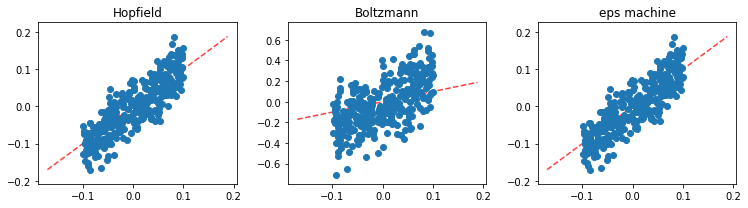

In [10]:
#n_eps = len(eps_list)
nx,ny = 3,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

lims = [np.min([w_true, w2]), np.max([w_true, w2])]
#for i,eps in enumerate(eps_list):
#ax[0].set_title('eps=%s'%eps)

ax[0].set_title('Hopfield')
ax[0].scatter(w_true,w_hopfield)

ax[1].set_title('Boltzmann')
ax[1].scatter(w_true,w1)

ax[2].set_title('eps machine')
ax[2].scatter(w_true,w2)

for i in range(nx):
    ax[i].plot(lims,lims,'r--', alpha=0.75, zorder=0)

plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('fig23.pdf', format='pdf', dpi=100)

#fig, ax = plt.subplots()    
#lims = [np.min([w_true, w_trial1]), np.max([w_true, w_trial1])]
#ax.scatter(w_true,w_hopfield,label='Hopfield', alpha=0.4)
#ax.scatter(w_true,w_trial1,label='BM_sample',alpha=0.4)
#ax.scatter(w_true,w_trial3,label='eps',alpha=0.4)
#ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax.legend()
#plt.show()